# Local Regression of ranking

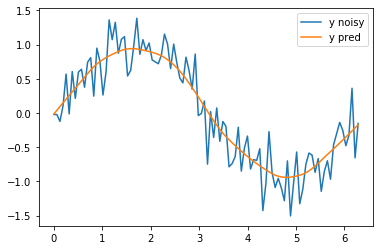

In [42]:
"""
This module implements the Lowess function for nonparametric regression.
Functions:
lowess Fit a smooth nonparametric regression curve to a scatterplot.
For more information, see
William S. Cleveland: "Robust locally weighted regression and smoothing
scatterplots", Journal of the American Statistical Association, December 1979,
volume 74, number 368, pp. 829-836.
William S. Cleveland and Susan J. Devlin: "Locally weighted regression: An
approach to regression analysis by local fitting", Journal of the American
Statistical Association, September 1988, volume 83, number 403, pp. 596-610.
"""

# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

from math import ceil
import numpy as np
from scipy import linalg


def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
#             beta = linalg.solve(A, b)
            beta = linalg.lstsq(A, b)[0]
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

if __name__ == '__main__':
    import math
    n = 100
    x = np.linspace(0, 2 * math.pi, n)
    y = np.sin(x) + 0.3 * np.random.randn(n)

    f = 0.25
    yest = lowess(x, y, f=f, iter=3)

    import pylab as pl
    pl.clf()
    pl.plot(x, y, label='y noisy')
    pl.plot(x, yest, label='y pred')
    pl.legend()
    pl.show()

# Step 3: Evaluate weights and derived GRNs

In [54]:
%matplotlib inline

import pickle
import matplotlib.pyplot as plt
import numpy as np
import ipdb
import copy
import seaborn as sns
# plt.rcParams['figure.dpi'] = 150

In [3]:
p2saved_file = '/data/jianhao/hepatocyte_update_dataset_101619/new_results_with_monoc_NF_100'
num_target_genes = 1000
num_TFs = 200

with open(p2saved_file, 'rb') as f:
    results_all = pickle.load(f)
    
results_all.keys()

dict_keys(['weight_dic', 'adjusted_r_squared', 'standard_error', 'TF_ids', 'query_targets'])

In [4]:
weight_dic = results_all['weight_dic']
TF_ids = results_all['TF_ids']
target_ids = results_all['query_targets']
print('length of TF: ',len(TF_ids))

for label in weight_dic:
    print(weight_dic[label].shape)
    break

length of TF:  200
(201, 1000)


In [5]:
results_all['weight_dic'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

# sort by ranking

In [96]:
def array_to_rank(in_arr):
    '''
    The bigger the element, the higher rank (larger number in ranks list)
    '''
    np_arr = np.array(in_arr)
    tmp = (np_arr).argsort()
    ranks = np.empty_like(tmp)
    ranks[tmp] = np.arange(len(np_arr))
    return ranks

def sort_TF_by_ranking(weight_dic, TF_ids, top_k = 5):
    '''
    weight_dic: {label: weight_mat}
    weight_mat: num_TF * num_target
    '''
    len_of_TF = len(TF_ids)
    weight_dic_new = copy.deepcopy(weight_dic)
    for label in weight_dic_new:
        weight_mat = np.abs(weight_dic_new[label])
        for col_idx in range(weight_mat.shape[1]):
            w_vector = weight_mat[:len_of_TF, col_idx]
            ranks = array_to_rank(w_vector)
            weight_dic_new[label][:len_of_TF, col_idx] = ranks
    
    # drop the bias term in weight_mat.
    for label in weight_dic_new:
        weight_mat = weight_dic_new[label]
        weight_dic_new[label] = weight_mat[:len_of_TF, :]
    
    # sort TFs based on their average ranking
    TF_importance = {}
    for label in weight_dic_new:
        
        average_importance = weight_dic_new[label].mean(axis = 1)
        tmp = average_importance.argsort()
        # larger weights/rank will be the last k.
        topk_TF = [TF_ids[x] for x in tmp[-top_k:]]
        
        fig, ax = plt.subplots()
        fig.dpi = 150
        max_rank = np.max(np.max(weight_dic_new[label]))
        im = ax.imshow(weight_dic_new[label] > max_rank - top_k)
        ax.set_xlabel('target index')
        ax.set_ylabel('TF ids')
        ax.set_yticks(tmp[-top_k:][::top_k//5])
        ax.set_yticklabels(topk_TF[::top_k // 5])
        ax.set_title('cluster label {}'.format(label))
        plt.show()
        
        rank_TF = array_to_rank(average_importance)
        TF_importance[label] = {}
        TF_importance[label]['TF_average_importance'] = average_importance
        TF_importance[label]['TF_ranking'] = rank_TF
        TF_importance[label]['top k TFs'] = topk_TF
    return TF_importance, weight_dic_new


In [97]:
test_arr = [5, 2, 4, 1]
test_rank = array_to_rank(test_arr)
print(test_rank)

[3 1 2 0]


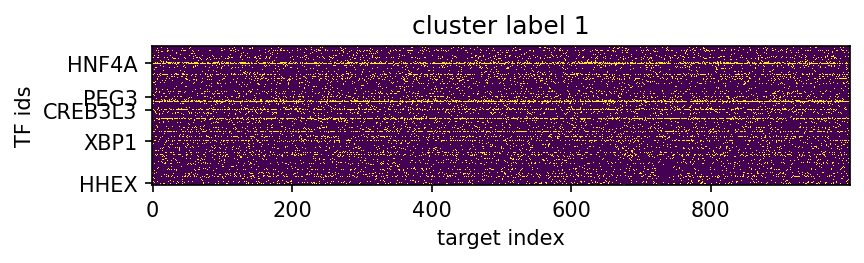

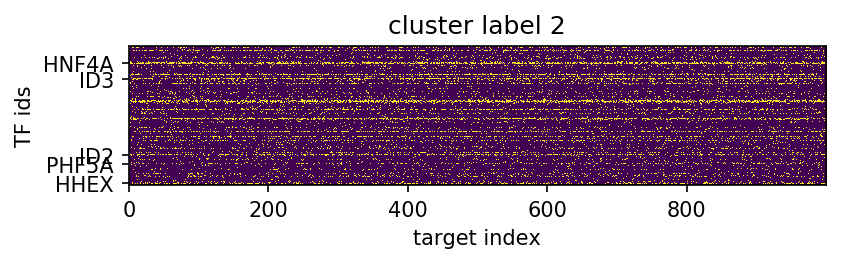

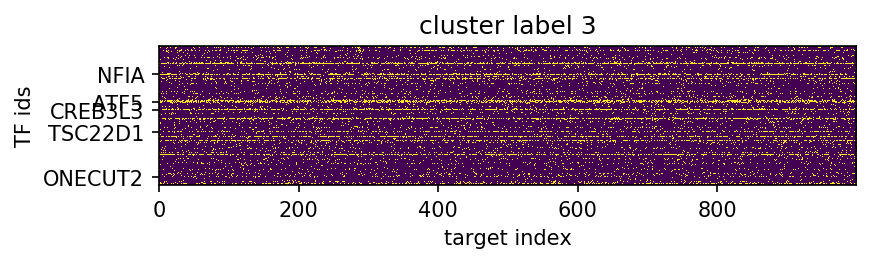

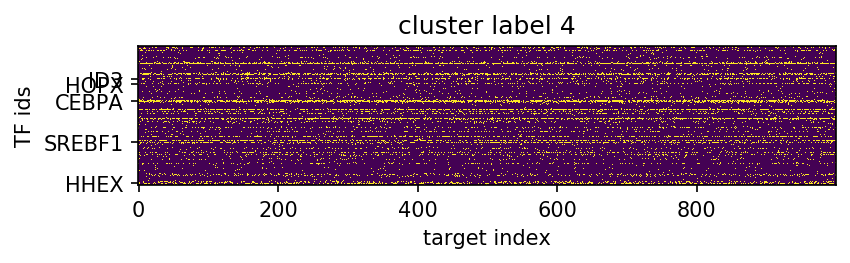

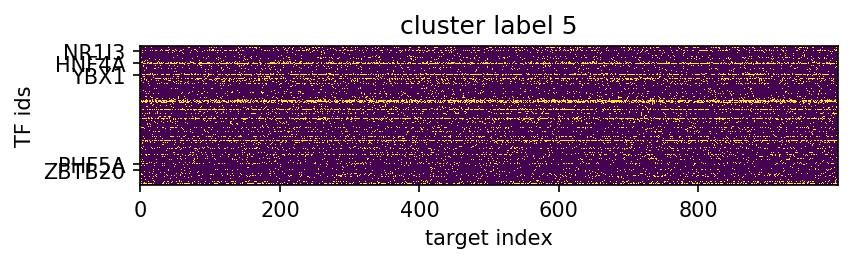

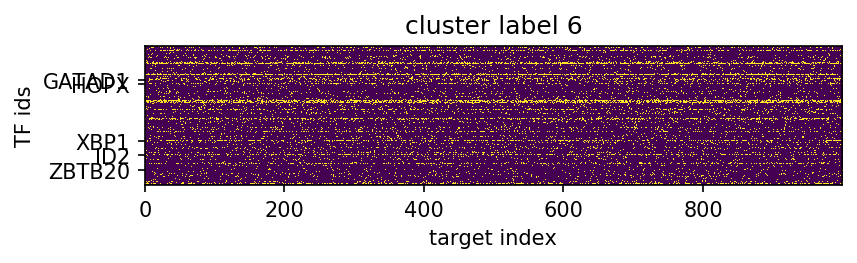

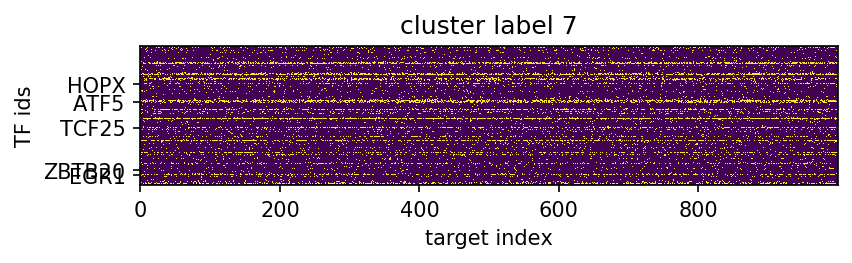

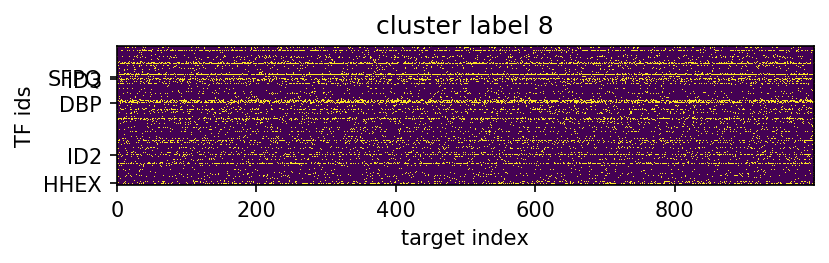

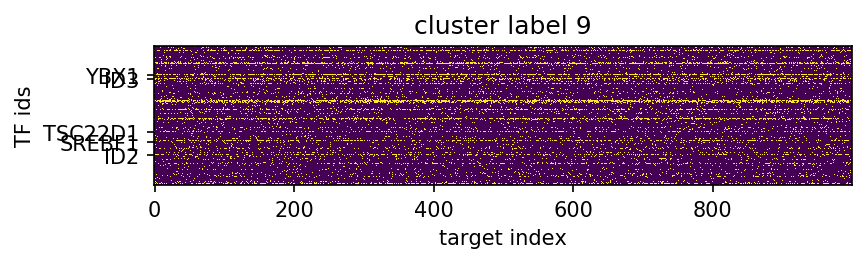

In [98]:
TF_ranking, weight_dic_ranking = sort_TF_by_ranking(weight_dic, TF_ids, 20)
# print(weight_dic_ranking)

In [99]:
list_of_important_TF = []
for label in TF_ranking:
    print([label])
    print(TF_ranking[label]['top k TFs'])
    for tf in TF_ranking[label]['top k TFs']:
        list_of_important_TF.append(tf)

[1]
['HHEX', 'ID3', 'NR1I3', 'KLF15', 'PEG3', 'NR3C1', 'ID2', 'FOXQ1', 'XBP1', 'TFDP2', 'CEBPA', 'YBX1', 'HNF4A', 'ZBTB20', 'TSC22D1', 'PPARA', 'CREB3L3', 'JUND', 'CEBPB', 'ATF5']
[2]
['PHF5A', 'HES6', 'DBP', 'XBP1', 'HHEX', 'HOPX', 'TFDP2', 'NR1I3', 'ID2', 'TSC22D1', 'CREB3L3', 'PPARA', 'HNF4A', 'CEBPA', 'JUND', 'YBX1', 'ID3', 'CEBPB', 'ATF5', 'ZBTB20']
[3]
['NFIA', 'SREBF1', 'HNF4A', 'NR1I3', 'ONECUT2', 'PPARA', 'HHEX', 'DBP', 'TSC22D1', 'ID3', 'XBP1', 'TFDP2', 'ATF5', 'CEBPA', 'ID2', 'YBX1', 'CREB3L3', 'ZBTB20', 'JUND', 'CEBPB']
[4]
['HOPX', 'PROX1', 'NR1I3', 'RORA', 'HHEX', 'TFDP2', 'NCOR1', 'PPARA', 'ID3', 'ONECUT2', 'NFIA', 'XBP1', 'SREBF1', 'YBX1', 'CREB3L3', 'JUND', 'CEBPA', 'ATF5', 'CEBPB', 'ZBTB20']
[5]
['PHF5A', 'ZFP91', 'HOPX', 'PPARA', 'HNF4A', 'SREBF1', 'ID2', 'TFDP2', 'NR1I3', 'HHEX', 'DBP', 'ID3', 'ZBTB20', 'JUND', 'CREB3L3', 'XBP1', 'YBX1', 'ATF5', 'CEBPA', 'CEBPB']
[6]
['GATAD1', 'HES6', 'TSC22D1', 'PPARA', 'HOPX', 'ID3', 'PHF5A', 'CREB3L3', 'ID2', 'NR1I3', 'HNF4A', '

In [100]:
union_of_TFs = set(list_of_important_TF)
print(union_of_TFs)
index_of_union_TF = [TF_ids.index(tf) for tf in union_of_TFs]
print(index_of_union_TF)
print('- ' * 7) 
print([TF_ids[x] for x in index_of_union_TF])
print(len(union_of_TFs))

{'TCF25', 'XBP1', 'GATAD1', 'NR3C1', 'PROX1', 'HNF4A', 'HOPX', 'NR1I3', 'ZBTB20', 'SFPQ', 'CEBPA', 'ZFP91', 'PEG3', 'TFDP2', 'KLF15', 'ATF5', 'HES6', 'YBX1', 'RORA', 'EGR1', 'JUND', 'NCOR1', 'HHEX', 'ID3', 'SREBF1', 'ID2', 'PPARA', 'ONECUT2', 'NFIA', 'PHF5A', 'TFAM', 'CREB3L3', 'CEBPB', 'DBP', 'FOXQ1', 'TSC22D1'}
[117, 136, 49, 187, 8, 25, 55, 7, 178, 44, 79, 195, 73, 130, 64, 80, 3, 42, 128, 185, 105, 139, 197, 47, 138, 156, 171, 188, 40, 169, 91, 92, 26, 82, 153, 123]
- - - - - - - 
['TCF25', 'XBP1', 'GATAD1', 'NR3C1', 'PROX1', 'HNF4A', 'HOPX', 'NR1I3', 'ZBTB20', 'SFPQ', 'CEBPA', 'ZFP91', 'PEG3', 'TFDP2', 'KLF15', 'ATF5', 'HES6', 'YBX1', 'RORA', 'EGR1', 'JUND', 'NCOR1', 'HHEX', 'ID3', 'SREBF1', 'ID2', 'PPARA', 'ONECUT2', 'NFIA', 'PHF5A', 'TFAM', 'CREB3L3', 'CEBPB', 'DBP', 'FOXQ1', 'TSC22D1']
36


In [104]:
# TF_ranking.keys()

In [105]:
# TF_ranking[1].keys()

In [106]:
# print(TF_ranking[1]['top k TFs'])
# print(TF_ranking[1]['TF_average_importance'])
# print(TF_ranking[1]['TF_ranking'])

# Ranking of avarage importance

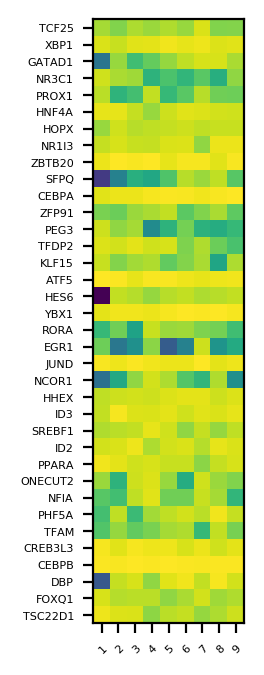

In [107]:
change_of_ranking_mat = np.empty((len(index_of_union_TF), len(TF_ranking)))
for label in TF_ranking:
    tmp = TF_ranking[label]['TF_ranking']
    union_TF = tmp[index_of_union_TF]
    change_of_ranking_mat[:, label - 1] = union_TF

fig, ax = plt.subplots(dpi = 200)
ax.imshow(change_of_ranking_mat)
ax.set_yticks(range(len(index_of_union_TF)))
ax.set_yticklabels([TF_ids[x] for x in index_of_union_TF], fontsize = 4)
ax.set_xticks(range(len(TF_ranking)))
ax.set_xticklabels([x + 1 for x in range(len(TF_ranking))], fontsize = 4)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# fig=plt.figure(dpi = 500)
# plt.rcParams['figure.figsize'] = [20, 5]
# plt.rcParams.update({'font.size': 14})
plt.show()
    

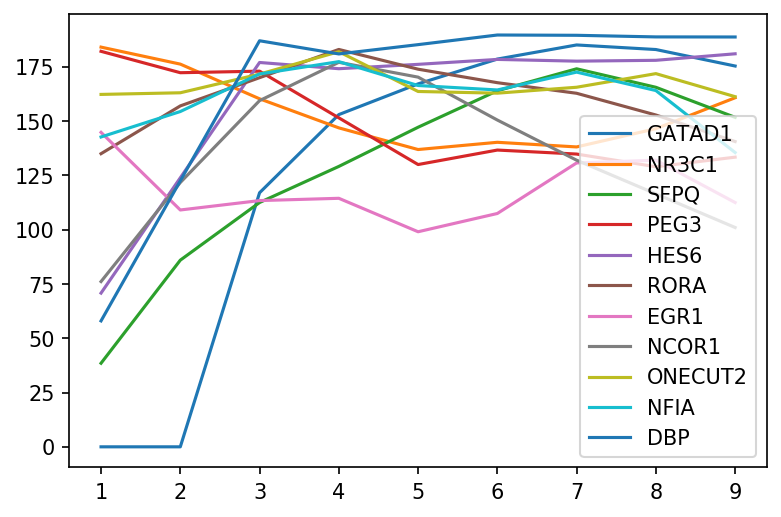

In [108]:
x = np.arange(1, 9+1)
y_var = change_of_ranking_mat.var(axis = 1)
y_var_threshold = np.quantile(y_var, q = 0.70)
# print(len(y_var))

plt.rcParams['figure.dpi'] = 150
for idx, row in enumerate(change_of_ranking_mat):
    f = 0.25
    if row.var() >= y_var_threshold:
        yest = lowess(x, row, f=f, iter=3)
        plt.plot(x, yest, label = TF_ids[index_of_union_TF[idx]])    

plt.legend()
# fig=plt.figure(dpi = 500)
plt.show()

# Average Ranking, raw value of 

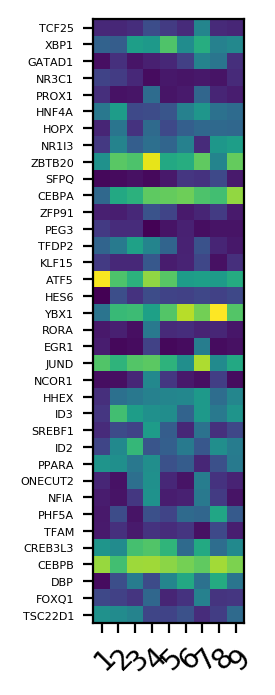

In [109]:
change_of_ranking_mat = np.empty((len(index_of_union_TF), len(TF_ranking)))
for label in TF_ranking:
    tmp = TF_ranking[label]['TF_average_importance']
    union_TF = tmp[index_of_union_TF]
    change_of_ranking_mat[:, label - 1] = union_TF

fig, ax = plt.subplots(dpi = 200)
ax.imshow(change_of_ranking_mat)
ax.set_yticks(range(len(index_of_union_TF)))
ax.set_yticklabels([TF_ids[x] for x in index_of_union_TF], fontsize = 4)
ax.set_xticks(range(len(TF_ranking)))
ax.set_xticklabels(x + 1 for x in range(len(TF_ranking)))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

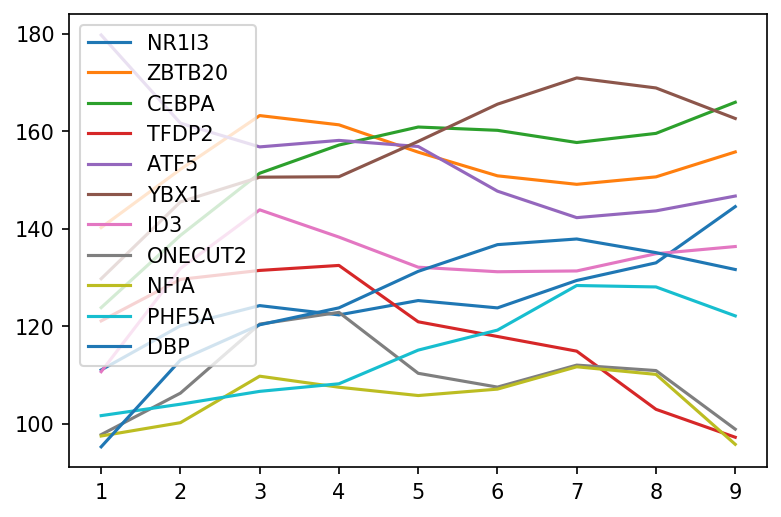

In [111]:
x = np.arange(1, 9+1)
y_var = change_of_ranking_mat.var(axis = 1)
y_var_threshold = np.quantile(y_var, q = 0.70)
# print(len(y_var))

plt.rcParams['figure.dpi'] = 150
for idx, row in enumerate(change_of_ranking_mat):
    f = 0.25
    if row.var() >= y_var_threshold:
        yest = lowess(x, row, f=f, iter=3)
        plt.plot(x, yest, label = TF_ids[index_of_union_TF[idx]])    

plt.legend()
# fig=plt.figure(dpi = 500)
plt.show()

# sort by weights [Not useful]

In [78]:
def sort_TF_by_weights(weight_dic, TF_ids, top_k = 5):
    len_of_TF = len(TF_ids)
    weight_dic_new = copy.deepcopy(weight_dic)
    
    # drop the bias term in weight_mat.
    for label in weight_dic_new:
        weight_mat = np.abs(weight_dic_new[label])
        weight_dic_new[label] = weight_mat[:len_of_TF, :]
    
    # sort TFs based on their average weights
    TF_importance = {}
    for label in weight_dic_new:
        
        average_importance = weight_dic_new[label].mean(axis = 1)
        # argsort uses ascending order
        tmp = (-average_importance).argsort()
        topk_TF = [TF_ids[x] for x in tmp[-top_k:]]
        
        fig, ax = plt.subplots()
        im = ax.imshow(weight_dic_new[label] > weight_dic_new[label].mean())
        ax.set_xlabel('target index')
        ax.set_ylabel('TF ids')
        ax.set_yticks(tmp[:top_k])
        ax.set_yticklabels(topk_TF)
        ax.set_title('cluster label {}'.format(label))
        plt.show()
        
        rank_TF = array_to_rank(average_importance)
        TF_importance[label] = {}
        TF_importance[label]['TF_average_importance'] = average_importance
        TF_importance[label]['TF_ranking'] = rank_TF
        TF_importance[label]['top k TFs'] = topk_TF
    return TF_importance, weight_dic_new


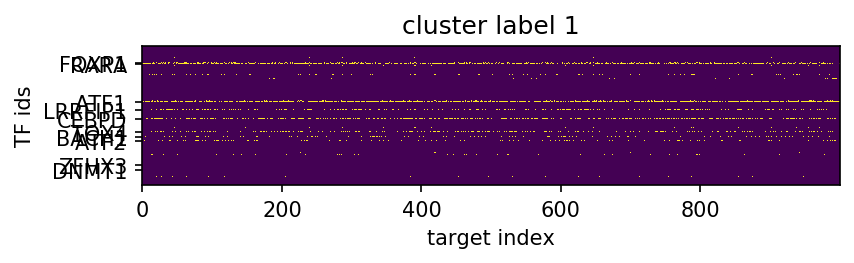

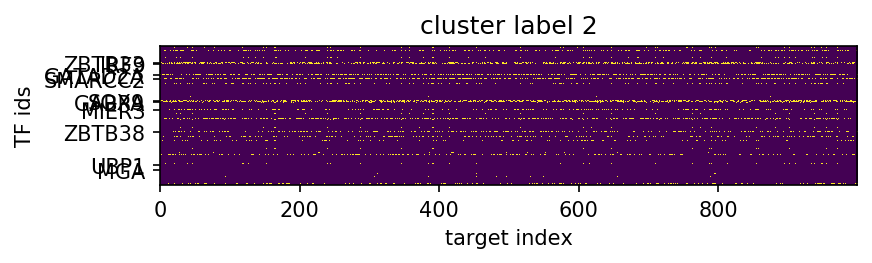

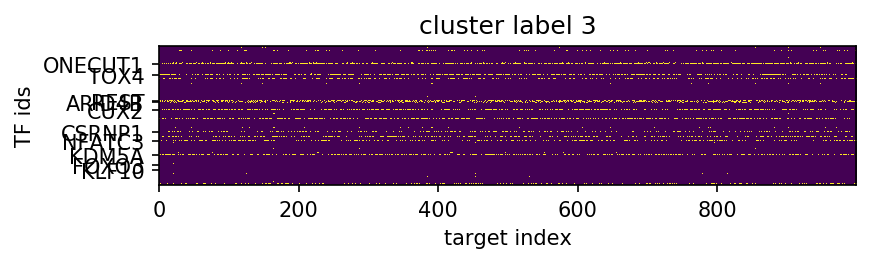

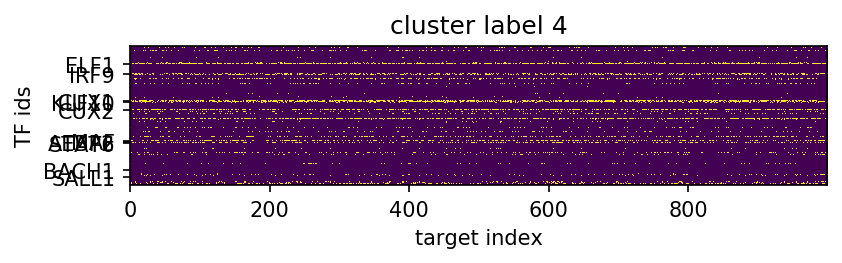

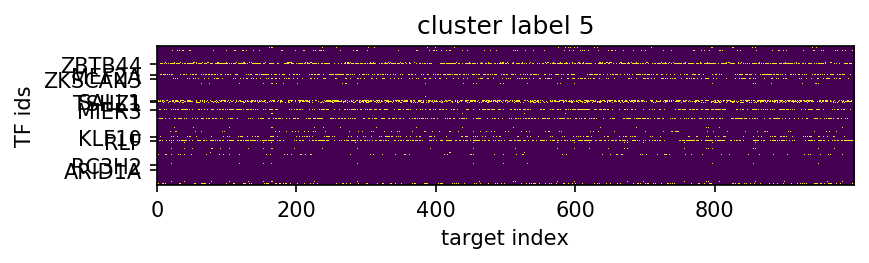

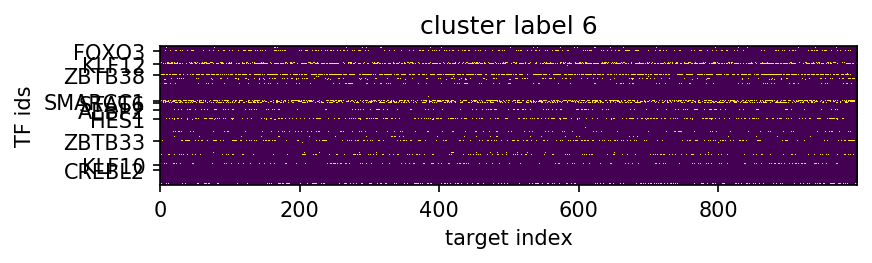

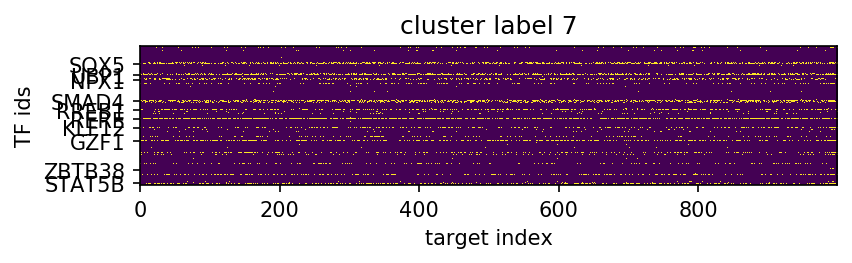

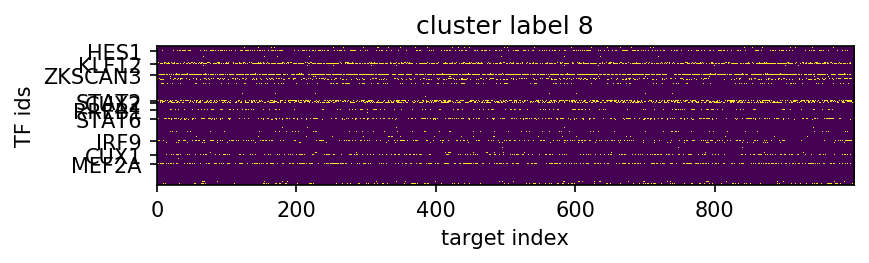

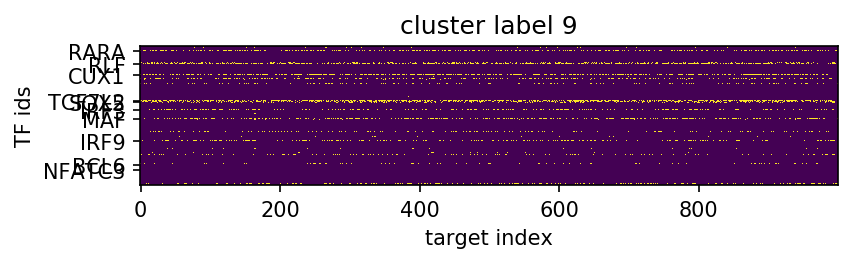

In [79]:
TF_ranking, weight_dic_ranking = sort_TF_by_weights(weight_dic, TF_ids, 10)

In [82]:
list_of_important_TF = []
for label in TF_ranking:
#     print(int2label_dict[label])
    print(TF_ranking[label]['top k TFs'])
    for tf in TF_ranking[label]['top k TFs']:
        list_of_important_TF.append(tf)

['ATF1', 'RARA', 'LRRFIP1', 'TOX4', 'ZFHX3', 'DNMT1', 'CEBPD', 'ATF2', 'FOXP1', 'BACH1']
['MIER3', 'IRF9', 'GABPA', 'MGA', 'UBP1', 'SMARCC2', 'ZBTB33', 'GATAD2A', 'ZBTB38', 'SOX9']
['CUX2', 'ONECUT1', 'NFATC3', 'TOX4', 'CSRNP1', 'KLF10', 'REST', 'KDM5A', 'FOXO3', 'ARID4B']
['ELF1', 'BACH1', 'CUX2', 'KLF10', 'CUX1', 'AEBP2', 'MAF', 'STAT6', 'SALL1', 'IRF9']
['RLF', 'MIER3', 'ZBTB44', 'MEF2A', 'SALL1', 'TSHZ1', 'ARID1A', 'RC3H2', 'ZKSCAN3', 'KLF10']
['ZBTB38', 'KLF12', 'SMARCC1', 'AEBP2', 'ZBTB33', 'FOXO3', 'CREBL2', 'KLF10', 'STAT6', 'HES1']
['UBP1', 'RERE', 'RREB1', 'GZF1', 'ZBTB38', 'SMAD4', 'STAT5B', 'SOX5', 'KLF12', 'NFX1']
['ZKSCAN3', 'KLF12', 'MEF2A', 'STAT2', 'IRF9', 'HES1', 'RREB1', 'CUX2', 'CUX1', 'STAT6']
['RLF', 'CUX1', 'IRF3', 'TCF7L2', 'RARA', 'NFATC3', 'IRF9', 'BCL6', 'MAF', 'SOX5']


In [83]:
union_of_TFs = set(list_of_important_TF)
print(union_of_TFs)
index_of_union_TF = [TF_ids.index(tf) for tf in union_of_TFs]
print(index_of_union_TF)
print([TF_ids[x] for x in index_of_union_TF])

{'IRF3', 'ZBTB44', 'KLF12', 'KDM5A', 'TCF7L2', 'CEBPD', 'TOX4', 'RLF', 'DNMT1', 'SMARCC2', 'MIER3', 'FOXO3', 'ZFHX3', 'RC3H2', 'CREBL2', 'SOX5', 'REST', 'ZBTB33', 'CUX2', 'ATF2', 'AEBP2', 'NFATC3', 'NFX1', 'FOXP1', 'ONECUT1', 'CSRNP1', 'CUX1', 'MEF2A', 'MAF', 'RREB1', 'STAT5B', 'STAT6', 'TSHZ1', 'ARID1A', 'KLF10', 'MGA', 'IRF9', 'STAT2', 'SALL1', 'SMARCC1', 'BACH1', 'BCL6', 'SMAD4', 'LRRFIP1', 'UBP1', 'GATAD2A', 'ARID4B', 'GZF1', 'ZBTB38', 'HES1', 'SOX9', 'ELF1', 'RERE', 'ATF1', 'ZKSCAN3', 'RARA', 'GABPA'}
[81, 127, 125, 68, 199, 174, 121, 43, 126, 101, 155, 88, 114, 12, 70, 72, 56, 28, 58, 14, 71, 113, 37, 65, 129, 135, 60, 84, 115, 154, 145, 99, 192, 46, 165, 18, 122, 100, 111, 132, 180, 175, 189, 2, 134, 104, 151, 20, 131, 176, 149, 124, 48, 172, 152, 143, 179]
['IRF3', 'ZBTB44', 'KLF12', 'KDM5A', 'TCF7L2', 'CEBPD', 'TOX4', 'RLF', 'DNMT1', 'SMARCC2', 'MIER3', 'FOXO3', 'ZFHX3', 'RC3H2', 'CREBL2', 'SOX5', 'REST', 'ZBTB33', 'CUX2', 'ATF2', 'AEBP2', 'NFATC3', 'NFX1', 'FOXP1', 'ONECUT1',

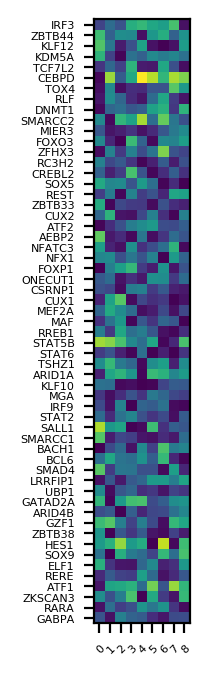

In [89]:
change_of_ranking_mat = np.empty((len(index_of_union_TF), len(TF_ranking)))
for label in TF_ranking:
    tmp = TF_ranking[label]['TF_ranking']
    union_TF = tmp[index_of_union_TF]
    change_of_ranking_mat[:, label - 1] = union_TF

fig, ax = plt.subplots(dpi = 200)
ax.imshow(change_of_ranking_mat)
ax.set_yticks(range(len(index_of_union_TF)))
ax.set_yticklabels([TF_ids[x] for x in index_of_union_TF], fontsize = 4)
ax.set_xticks(range(len(TF_ranking)))
ax.set_xticklabels([x for x in range(len(TF_ranking))], fontsize = 4)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()
    

In [92]:
# change_of_ranking_mat = np.empty((len(index_of_union_TF), len(TF_ranking)))
# for label in TF_ranking:
#     tmp = TF_ranking[label]['TF_average_importance']
#     union_TF = tmp[index_of_union_TF]
#     change_of_ranking_mat[:, label - 1] = -union_TF

# fig, ax = plt.subplots()
# ax.imshow(change_of_ranking_mat)
# ax.set_yticks(range(len(index_of_union_TF)))
# ax.set_yticklabels([TF_ids[x] for x in index_of_union_TF], fontsize = 4)
# ax.set_xticks(range(len(TF_ranking)))
# ax.set_xticklabels([x for x in range(len(TF_ranking))])
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
# plt.show()